In [12]:
import xarray as xr
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from xgcm import Grid
import os
import zarr 
import dask
import regionmask

In [13]:
ds = xr.open_zarr("data/ssh.zarr")
basins = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50
mask = basins.mask(ds.Longitude,ds.Latitude)

In [33]:
print(ds.Time)

<xarray.DataArray 'Time' (Time: 1878)>
array(['1997-04-12T12:00:00.000000000', '1997-04-17T12:00:00.000000000',
       '1997-04-22T12:00:00.000000000', ..., '2022-12-12T12:00:00.000000000',
       '2022-12-17T12:00:00.000000000', '2022-12-22T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 1997-04-12T12:00:00 ... 2022-12-22T12:00:00


In [15]:
dsa = ds.groupby('Time.month').sum()
dsa

<xarray.Dataset>
Dimensions:     (month: 12, Latitude: 960, nv: 2, Longitude: 2160)
Coordinates:
  * Latitude    (Latitude) float32 -79.92 -79.75 -79.58 ... 79.58 79.75 79.92
  * Longitude   (Longitude) float32 0.08333 0.25 0.4167 ... 359.6 359.8 359.9
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    Lat_bounds  (month, Latitude, nv) float32 dask.array<chunksize=(1, 960, 2), meta=np.ndarray>
    Lon_bounds  (month, Longitude, nv) float32 dask.array<chunksize=(1, 2160, 2), meta=np.ndarray>
    SLA         (month, Latitude, Longitude) float32 dask.array<chunksize=(1, 240, 540), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.6
    DOI:                    10.5067/SLREF-CDRV3
    Data_Pnts_Each_Sat:     {"5": 683577, "1007": 325186}
    Institution:            Jet Propulsion Laboratory
    SLA_Global_MEAN:        0.08430899325786308
    SLA_Global_STD:         0.10057130052683155
    ...                     ...
    source_version:         commit 58c7da13c0c0069ae940c33a82bf1544b7d991bf
    summary:                Sea level anomaly grids from altimeter data using...
    time_coverage_end:      2022-12-22
    time_coverage_start:    2022-12-22
    title:                  Sea Level Anomaly Estimate based on Altimeter Dat...
    version_number:         2205

In [16]:
w = ds.resample(Time='1M').mean()
w

<xarray.Dataset>
Dimensions:     (Time: 309, Latitude: 960, nv: 2, Longitude: 2160)
Coordinates:
  * Latitude    (Latitude) float32 -79.92 -79.75 -79.58 ... 79.58 79.75 79.92
  * Longitude   (Longitude) float32 0.08333 0.25 0.4167 ... 359.6 359.8 359.9
  * Time        (Time) datetime64[ns] 1997-04-30 1997-05-31 ... 2022-12-31
Dimensions without coordinates: nv
Data variables:
    Lat_bounds  (Time, Latitude, nv) float32 dask.array<chunksize=(1, 960, 2), meta=np.ndarray>
    Lon_bounds  (Time, Longitude, nv) float32 dask.array<chunksize=(1, 2160, 2), meta=np.ndarray>
    SLA         (Time, Latitude, Longitude) float32 dask.array<chunksize=(1, 240, 540), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.6
    DOI:                    10.5067/SLREF-CDRV3
    Data_Pnts_Each_Sat:     {"5": 683577, "1007": 325186}
    Institution:            Jet Propulsion Laboratory
    SLA_Global_MEAN:        0.08430899325786308
    SLA_Global_STD:         0.10057130052683155
    ...                     ...
    source_version:         commit 58c7da13c0c0069ae940c33a82bf1544b7d991bf
    summary:                Sea level anomaly grids from altimeter data using...
    time_coverage_end:      2022-12-22
    time_coverage_start:    2022-12-22
    title:                  Sea Level Anomaly Estimate based on Altimeter Dat...
    version_number:         2205

In [6]:
def sshv(ssh):
    ssh = ssh.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
    grid = Grid(ssh, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
    ssh_1diffX = grid.diff(ssh.SLA, axis="X")
    ssh_1diffY = grid.diff(ssh.SLA, axis="Y")
    ssh_1difflon = grid.diff(ssh.Lon_bounds, axis="X")
    delet = ssh_1diffX
    lamda = ssh_1difflon.isel(nv=1)
    delx = np.radians(lamda)*6371000*np.cos(np.radians(ssh.Latitude))
    f = 4*np.pi*np.sin(np.radians(ssh.Latitude))/(3600*24)
    v = (9.81*delet)/(f*delx)
    iv = grid.interp(v, axis = 'X')
    return iv.where((ssh.Latitude>1)|(ssh.Latitude<-1),0)

In [7]:
def sshu(ssh):
    ssh = ssh.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
    grid = Grid(ssh, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
    ssh_1diffX = grid.diff(ssh.SLA, axis="X")
    ssh_1diffY = grid.diff(ssh.SLA, axis="Y")
    ssh_1difflat = grid.diff(ssh.Lat_bounds, axis="Y")
    delet = ssh_1diffY
    theta = ssh_1difflat.isel(nv=1)
    dely = np.radians(theta)*6371000
    f = 4*np.pi*np.sin(np.radians(ssh.Latitude))/(3600*24)
    interpf = grid.interp(f, axis='Y')
    u = -(9.81*delet)/(interpf*dely)
    iu = grid.interp(u, axis = 'Y')
    return iu.where((ssh.Latitude>1)|(ssh.Latitude<-1),0)

In [8]:
meanu = sshu(w).mean("Time")
meanv = sshv(w).mean("Time")
deru = sshu(w)- meanu
derv = sshv(w)- meanv
dsa = w.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
grid = Grid(dsa, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
ssh_1difflon = dsa.Lon_bounds.isel(nv = 1)-dsa.Lon_bounds.isel(nv=0)
lamda = ssh_1difflon
delx = np.radians(lamda)*6371000*np.cos(np.radians(dsa.Latitude))
ssh_1difflat = dsa.Lat_bounds.isel(nv = 1)-dsa.Lat_bounds.isel(nv=0)
theta = ssh_1difflat
dely = np.radians(theta)*6371000
area = dely*delx
MKE = (1/2*1025*(meanu**2+meanv**2))
EKE = (1025*1/2*((sshu(w)**2)+(sshv(w)**2)))
CT = (1025*(meanu*deru+meanv*derv))
KE = MKE+CT
EKEBAR=((1/2)*1025)*(deru**2+derv**2)

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


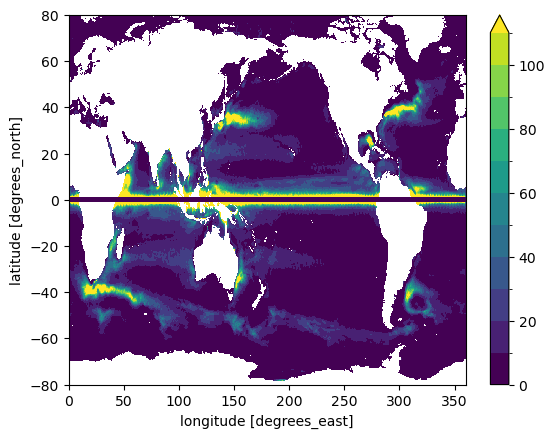

In [9]:
EKEBAR.mean("Time").plot(levels=np.arange(0,120,10))